# Google Kubernetes Engine PostgreSQL Laufzeitanalyse
Im Rahmen der folgenden Untersuchung werden verschiedene Maschinentypen der Google Kubernetes Engine (kurz GKE) hinsichtlich der Laufzeit und der Transaktionsdauer einer PostgreSQL-Datenbank analysiert. Hierbei wird jeweils ein Kubernetes-Cluster erstellt, das aus einem Knoten des jeweiligen Maschinentyps besteht, auf dem ein CloudNativePG-Cluster gestartet wird. Letzteres besteht, da es sich hierbei um einen reinen Leistungsvergleich handelt, lediglich aus einem Clusterknoten. Damit ist gewährleistet, dass bei dem gewählten Benchmark keine Clusterauslagerungen stattfinden und wir somit die reine Performance der Maschine betrachten können.
## Benchmark und Details
Google verwendet für die Knoten bzw. die Kubernetes-Implementierung den klassischen Containerd-Service. Dieser bildet die Schnittstelle zwischen dem Host-Betriebssystem und Kubernetes. Benötigt eine Applikation Hardware-Ressourcen, werden diese wie bei einem Bare-Metal-Server sofort bereitgestellt. Da wir in der folgenden Versuchsreihe einen einzelnen Clusterknoten verwenden, muss Kubernetes keine Synchronisation zwischen Knoten vornehmen. Somit können wir die Performance von Kubernetes, dem Containerd-Service, dem Host-Betriebssystem und der Hardware als gute Messumgebung nutzen, und es ist kein Overhead zu erwarten.

Als Benchmark-Suite wurde der von PostgreSQL selbst entwickelte pgbench verwendet. Dieser wird auf einer weiteren GCloud-VM ausgeführt und somit, im Gegensatz zur vorherigen Messreihe, nicht im Cluster selbst. Damit repräsentiert die erzielte Leistung lediglich die Clusterleistung selbst, ohne dass ein Overhead durch den im Cluster ausgeführten Benchmark entsteht.

In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import random

colors = ["blue", "green", "red", "cyan", "magenta", "yellow"]

def visualize(data, title):
    df = pd.DataFrame(data)

    df_sorted = df.sort_values("CPU CORES ALLOCATED")

    plt.figure(figsize=(10, 6))
    plt.plot(
        df_sorted["CPU CORES ALLOCATED"], 
        df_sorted["TPS"], 
        marker="o", 
        linestyle="-", 
        color=f"#{random.randint(0, 0xFFFFFF):06x}", 
        label="Transactions per Second",
        linewidth=4,
        markersize=15,
    )
    plt.title(title, fontsize=16)
    plt.xlabel("CPU Cores Allocated", fontsize=14)
    plt.ylabel("Transactions per Second", fontsize=14)
    plt.xticks(df_sorted["CPU CORES ALLOCATED"], fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis="both", linestyle="-", alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

## E2 Standard
Zunächst untersuchen wir einen der klassischen Maschinentypen in einer Google-Cloud-Umgebung. Die E2-Maschinen werden von Google selbst als kostengünstige Alltags-VMs beworben. Sie können auf unterschiedlichen Hardware-Architekturen laufen, wodurch Google weitere Kosten sparen kann, indem beispielsweise Knoten in ihrer Infrastruktur, die derzeit nicht genutzt werden, vermietet werden. Dabei kommen alle gängigen x86_64-Prozessorhersteller zum Einsatz. In unseren Tests wurden uns vor allem AMD-Epyc-Prozessoren zur Verfügung gestellt.

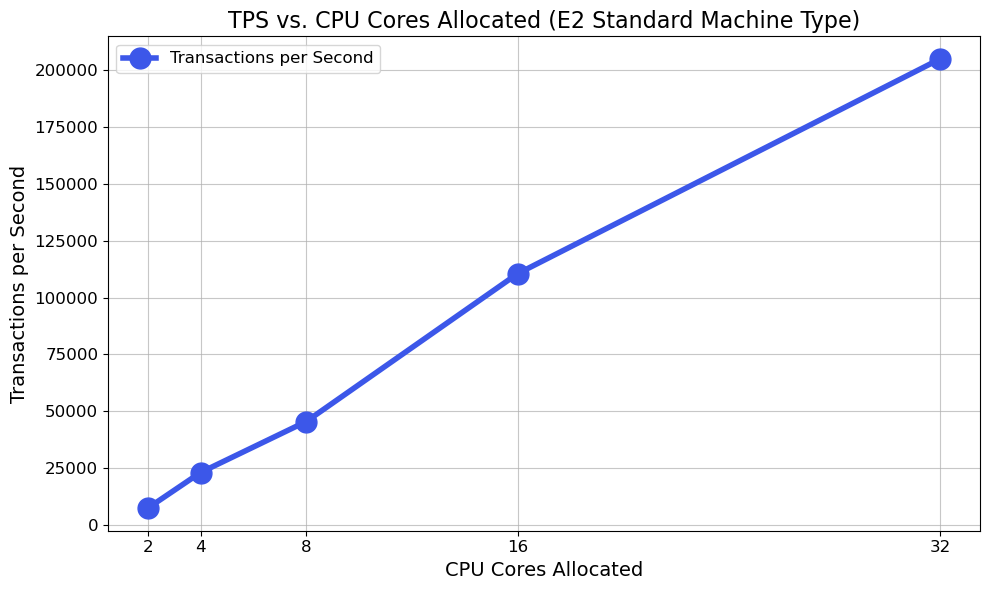

In [69]:
data = {
    "MACHINE TYPE": [
        "e2-standard-32", 
        "e2-standard-16", 
        "e2-standard-8", 
        "e2-standard-4",
        "e2-standard-2"
    ],
    "CPU TYPE": ["e2", "e2", "e2", "e2", "e2"],
    "CPU CORES ALLOCATED": [32, 16, 8, 4, 2],
    "TPS": [205116.731071, 110503.320857, 45397.606615, 22954.238914, 7222.776990]
}
visualize(data, "TPS vs. CPU Cores Allocated (E2 Standard Machine Type)")

### Auswertung
Die obere Messreihe zeigt deutlich eine lineare Skalierung der Transaktionen pro Sekunde. Dies spricht für einen ausgezeichneten Parallelisierungsgrad der getesteten PostgreSQL-Implementierung. Dabei konnte auf einer 32-Kern-Maschine ein TPS-Spitzenwert von knapp 210.000 erreicht werden. Dieser Wert liegt auf Augenhöhe mit gängigen lokal gehosteten Datenbanken und kann problemlos durch das Hinzufügen weiterer Rechenkapazitäten in Form von Kernen nach oben skaliert werden.

Spannend ist hierbei auch, dass die Größe des Arbeitsspeichers keinen Einfluss auf die Transaktionsrate hat. Dies lässt sich vor allem durch die Architektur von PostgreSQL erklären, da diese eher auf CPU-Caching und direkten Festplattenzugriff als auf "In-Memory"-Verarbeitung setzt.

Eine Extrapolation der Kurve zeigt ein potenzielles lokales Maximum der TPS, das vermutlich bei etwa 64 Kernen mit 350.000 TPS erreicht wird.

## C3D Standard
Bei der C-Familie der Google-Cloud-Maschinen handelt es sich um Maschinentypen, die vor allem für rechenintensive Prozesse verwendet werden. Dabei können Prozessorarchitekturen sowie Hersteller explizit ausgewählt werden.

Die C3D-Maschinenfamilie nutzt die modernsten AMD-Epyc-Genoa-Prozessoren, die sich insbesondere durch ihre extrem großen Cache-Größen auszeichnen und bis zu 96 Kerne auf einem einzelnen Prozessor bieten. Hierbei werden vier NUMA-Domains verwendet.

Im Vergleich zur E2-Messreihe im vorherigen Abschnitt konnten für die C3D-Familie nur Maschinen mit 4 bis 16 Kernen getestet werden. Grund dafür ist, dass Google keine Zwei-Kern-Maschinen in dieser Familie anbietet und eine interne Richtlinie von Google die Nutzung von VMs mit mehr als 24 Kernen aus der C3D-Familie ohne spezielle Genehmigung verbietet. Möchte man dennoch mehr Kerne verwenden, muss hierfür eine Genehmigung bei Google beantragt werden.

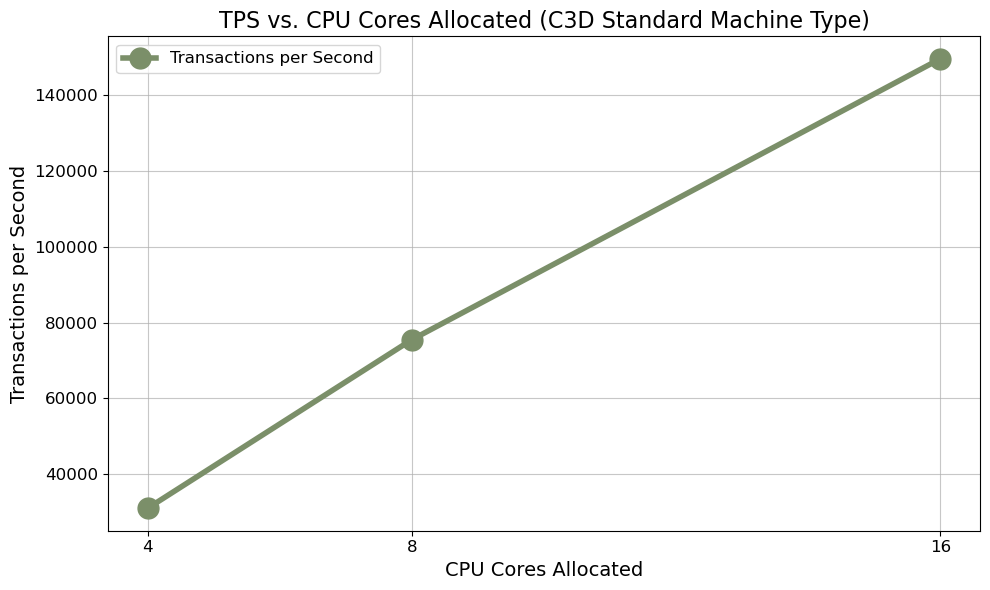

In [70]:
data = {
    "MACHINE TYPE": [
        "c3d-standard-16", 
        "c3d-standard-8", 
        "c3d-standard-4"
    ],
    "CPU TYPE": ["c3d", "c3d", "c3d"],
    "CPU CORES ALLOCATED": [16, 8, 4],
    "TPS": [149609.066347, 75511.570651, 31017.311826]
}
visualize(data, "TPS vs. CPU Cores Allocated (C3D Standard Machine Type)")

### Auswertung
Die durchgeführte Messreihe verdeutlicht hervorragend, wie stark Anwendungen von modernen Prozessorarchitekturen profitieren können. Die Prozessoren der E2-Familie besitzen zwar die gleiche Taktfrequenz wie die der C3D-Familie, jedoch sind letztere durchweg deutlich leistungsstärker. So erreichen wir mit 16 C3D-Kernen nahezu die gleiche Anzahl an Transaktionen pro Sekunde, die eine E2-Maschine mit der doppelten Anzahl an Prozessorkernen erzielen konnte. Gerade aber auch bei geringerer Prozessoranzahl sehen wir fast das doppelter der TPS Werte eine E2-Maschine

## C2 Standard

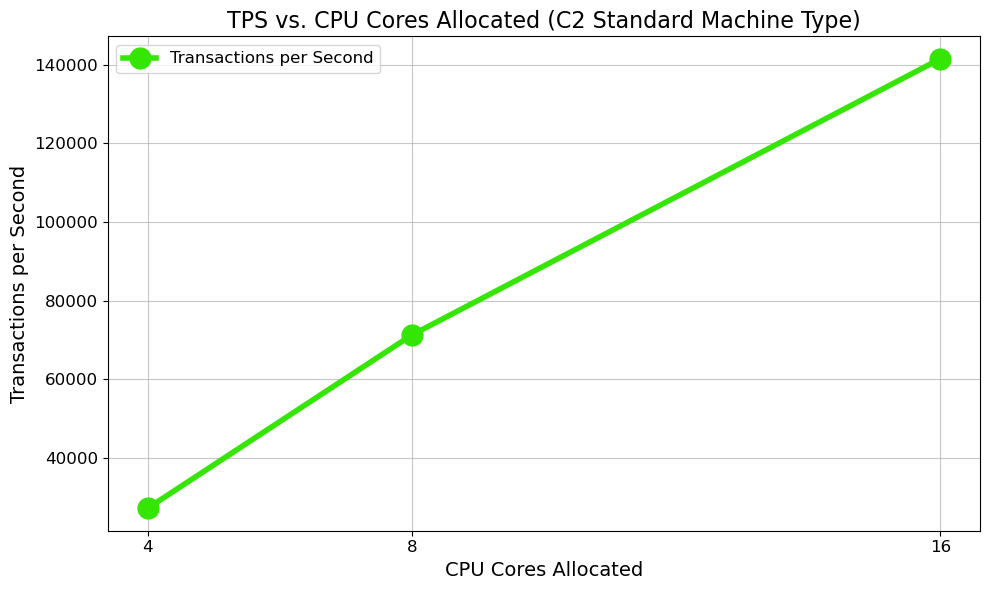

In [71]:
data = {
    "MACHINE TYPE": [
        "c2-standard-16", 
        "c2-standard-8", 
        "c2-standard-4"
    ],
    "CPU TYPE": ["c2", "c2", "c2"],
    "CPU CORES ALLOCATED": [16, 8, 4],
    "TPS": [141465.288866, 71311.623489, 27293.374996]
}
visualize(data, "TPS vs. CPU Cores Allocated (C2 Standard Machine Type)")

## E2 High CPU

## C3D High CPU

## C2 High CPU